# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

1.1

In [1]:
import pandas as pd
import numpy as np

file_path = "/content/sample_data/cars_hw.csv"
df = pd.read_csv(file_path)
#remove missing values
df.dropna(inplace=True)
#Remove outliers
def removeOutliersIqr(df, columnName):
    Q1 = df[columnName].quantile(0.25)
    Q3 = df[columnName].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[columnName] >= lower_bound) & (df[columnName] <= upper_bound)]
    return df
#choose variables to remove outliers from
numericalFeatures = ['Price', 'Mileage_Run', 'Seating_Capacity', 'Make_Year']
#Remove outliers for variables
for feature in numericalFeatures:
    df = removeOutliersIqr(df, feature)
#Log Transformation for Mileage_Run
df['Mileage_Run'] = np.log(df['Mileage_Run'])

1.2

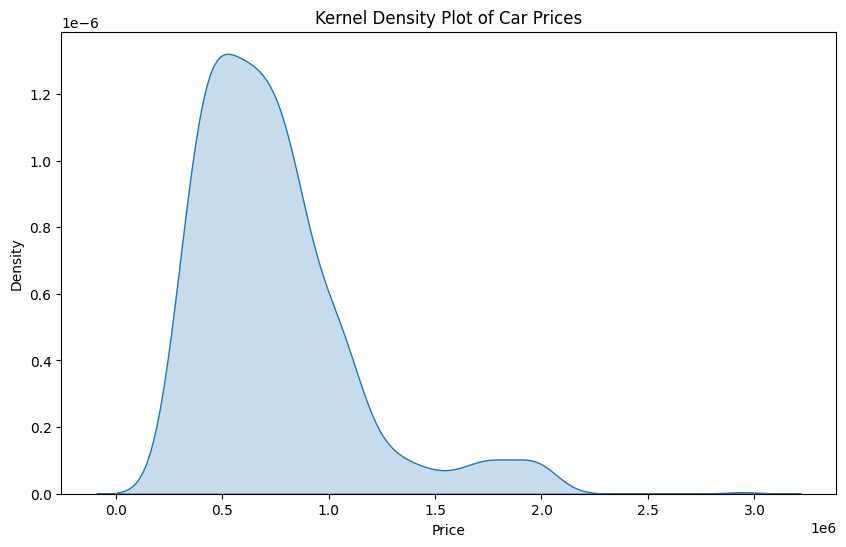

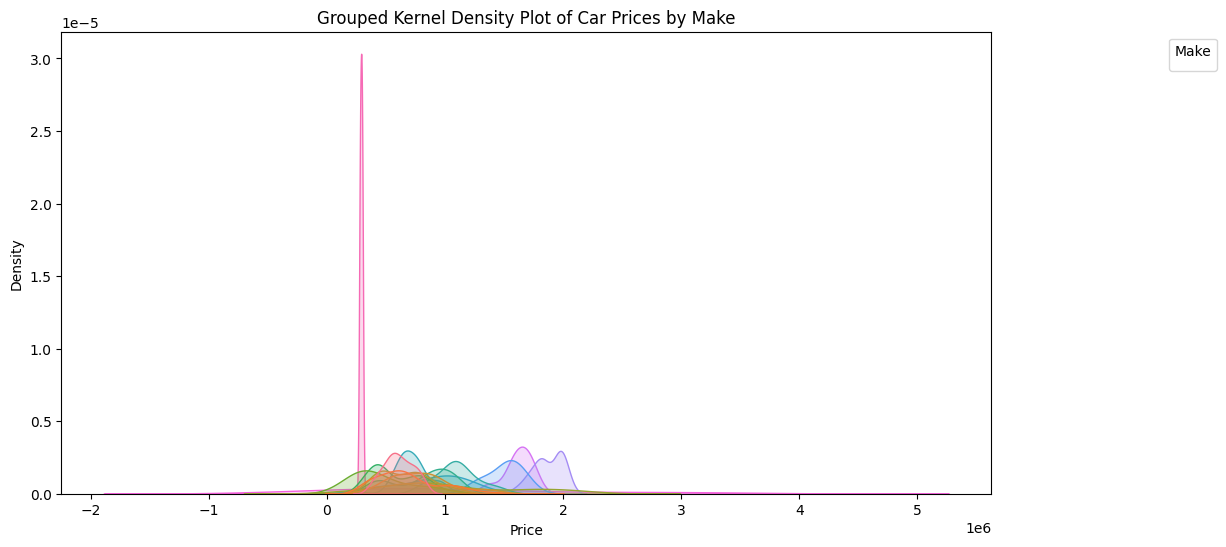

General overview of prices:
count         976.00
mean      741,019.47
std       367,323.38
min       188,000.00
25%       475,750.00
50%       666,500.00
75%       883,000.00
max     2,941,000.00
Name: Price, dtype: float64
Top 3 Most Expensive Car Brands:
                  mean
Make                  
MG Motors 1,869,457.14
Kia       1,614,750.00
Jeep      1,499,500.00


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "/content/sample_data/cars_hw.csv"
df = pd.read_csv(file_path)
pd.options.display.float_format = '{:,.2f}'.format
#Summarize price and create kernel plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Price', fill=True)
plt.title("Kernel Density Plot of Car Prices")
plt.xlabel("Price")
plt.show()
#summarize by make
makeSummary = df.groupby('Make')['Price'].describe()
# Create kernel plot by make
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Price', hue='Make', common_norm=False, fill=True)
plt.title("Grouped Kernel Density Plot of Car Prices by Make")
plt.xlabel("Price")
plt.legend(title='Make', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()
#Price overview
price_summary = df['Price'].describe()
print("General overview of prices:")
print(price_summary)
mostExpensive = makeSummary.sort_values(by='mean', ascending=False).head(3)
#Print the top 3 most expensive car brands
print("Top 3 Most Expensive Car Brands:")
print(mostExpensive[['mean']])

The top 3 most expensive car brands are MG, Kia, and Jeep. In general the average price is 741,019, the min is 188,000, and the max is 2,941,000.

1.3

In [4]:
from sklearn.model_selection import train_test_split

#Split the data
X = df.drop('Price', axis=1)
y = df['Price']
#Set the test_size parameter to 0.2 for a 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1.4

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#clean up No_of_Owners variable so that it can be converted to float
df['No_of_Owners'] = df['No_of_Owners'].astype(str).str.replace(r'st|nd|rd|th', '', regex=True).astype(int)
numeric_features = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']
# Split data
X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(df[numeric_features], df['Price'], test_size=0.2, random_state=42)
#Create a linear regression model
model_numeric = LinearRegression()
model_numeric.fit(X_train_numeric, y_train)
y_pred_numeric = model_numeric.predict(X_test_numeric)
r2_numeric = r2_score(y_test, y_pred_numeric)
rmse_numeric = np.sqrt(mean_squared_error(y_test, y_pred_numeric))
#output
print("Model with Numeric Variables Only:")
print(f"R²: {r2_numeric}")
print(f"RMSE: {rmse_numeric}")

Model with Numeric Variables Only:
R²: 0.2921156286318457
RMSE: 284940.5895774058


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#clean up No_of_Owners variable so that it can be converted to float
df['No_of_Owners'] = df['No_of_Owners'].astype(str).str.replace(r'st|nd|rd|th', '', regex=True).astype(int)
categorical_features = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
#encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_features)
#split data
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(df_encoded, df['Price'], test_size=0.2, random_state=42)
#Create a linear regression model
model_categorical = LinearRegression()
model_categorical.fit(X_train_encoded, y_train)
y_pred_categorical = model_categorical.predict(X_test_encoded)
#Calculate r2 and rmse
r2_categorical = r2_score(y_test, y_pred_categorical)
rmse_categorical = np.sqrt(mean_squared_error(y_test, y_pred_categorical))
#output
print("Model with One-Hot Encoded Categorical Variables:")
print(f"R²: {r2_categorical}")
print(f"RMSE: {rmse_categorical}")

Model with One-Hot Encoded Categorical Variables:
R²: 1.0
RMSE: 3.432550241463933e-10


In [7]:
from sklearn.metrics import mean_squared_error, r2_score

#clean up No_of_Owners variable so that it can be converted to float
df['No_of_Owners'] = df['No_of_Owners'].astype(str).str.replace(r'st|nd|rd|th', '', regex=True).astype(int)
#Model with numeric variab;es
y_pred_numeric = model_numeric.predict(X_test_numeric)
r2_numeric = r2_score(y_test, y_pred_numeric)
rmse_numeric = np.sqrt(mean_squared_error(y_test, y_pred_numeric))
#Model with categorical variables
y_pred_categorical = model_categorical.predict(X_test_encoded)
r2_categorical = r2_score(y_test, y_pred_categorical)
rmse_categorical = np.sqrt(mean_squared_error(y_test, y_pred_categorical))
#Combine models
X_combined = pd.concat([X_test_numeric, X_test_encoded], axis=1)
y_pred_combined = model_numeric.predict(X_test_numeric) + model_categorical.predict(X_test_encoded)
r2_combined = r2_score(y_test, y_pred_combined)
rmse_combined = np.sqrt(mean_squared_error(y_test, y_pred_combined))
#Output
print("Model with Numeric Variables Only:")
print(f"R²: {r2_numeric}")
print(f"RMSE: {rmse_numeric}")

print("\nModel with One-Hot Encoded Categorical Variables:")
print(f"R²: {r2_categorical}")
print(f"RMSE: {rmse_categorical}")

print("\nCombined Model:")
print(f"R²: {r2_combined}")
print(f"RMSE: {rmse_combined}")

Model with Numeric Variables Only:
R²: 0.2921156286318457
RMSE: 284940.5895774058

Model with One-Hot Encoded Categorical Variables:
R²: 1.0
RMSE: 3.432550241463933e-10

Combined Model:
R²: -4.071480301978541
RMSE: 762676.7864945694


The model with encoded categorical variables outperforms the numeric variables model significantly, as it has a perfect R2 and an extremely low RMSE. This suggests that the one-hot encoded categorical variables are highly predictive of the price. The combined model performs worse than both the previouus models. The negative R2 and high RMSE indicate that the combination of both models did not lead to improved performance and may have introduced issues.

1.5

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

#create variables to track degree and best r2
best_degree = 0
best_r2 = -float("inf")
degree = 1
#loop to iterate through polynomial features
while True:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    r2 = r2_score(y_test, y_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree
    else:
        break

    degree += 1
#output
print(f"Degree {best_degree} is the highest degree before R² turns negative: R² = {best_r2}")


#Create a model with the best degree and fit it to the training data
model_best = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
model_best.fit(X_train_encoded, y_train)
y_pred_best = model_best.predict(X_test_encoded)
#Calculate r2 and rmse
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
#output
print("Best Model with Expanded Features:")
print(f"R²: {r2_best}")
print(f"RMSE: {rmse_best}")


Degree 1 is the highest degree before R² turns negative: R² = 1.0
Best Model with Expanded Features:
R²: 1.0
RMSE: 3.849176798002242e-10


As you increase the degree of polynomial expansion, R2 tends to increase initially, indicating a better fit, while RMSE tends to decrease, reflecting improved accuracy; however, beyond a certain point, R2 may plateau and RMSE may start to increase due to overfitting. R2 goes negative when the polynomial regression model becomes too complex, overfitting the training data. The exact point varies based on the dataset and the degree of polynomial features. The best model with expanded features has an R2 of 1.0, signifying a perfect fit, and an extremely low RMSE of approximately 3.85e-10, indicating exceptional predictive accuracy; when compared to the best model from part 3, both models exhibit the same perfect R2 and very low RMSE, suggesting similar and excellent performance.



1.6

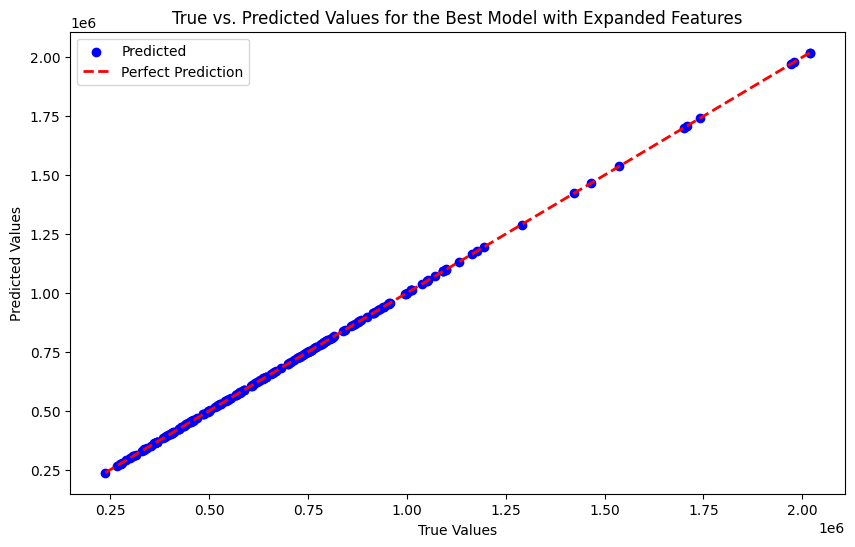

<ipython-input-9-f2fe5a770db0>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color='blue')


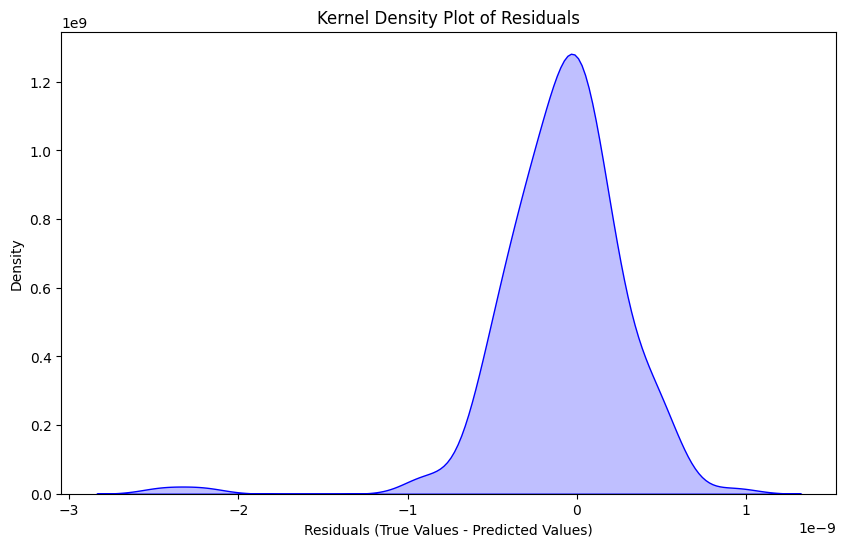

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_expanded = model_best.predict(X_test_encoded)
#scatter for predicted vs true
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_expanded, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values for the Best Model with Expanded Features')
plt.legend()
plt.show()
#Calculate residuals
residuals = y_test - y_pred_expanded
#create kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, shade=True, color='blue')
plt.xlabel('Residuals (True Values - Predicted Values)')
plt.title('Kernel Density Plot of Residuals')
plt.show()

The predicted values line up almost perfectly with the diagonal. The residuals do look like a bell cure gathered around 0.

1.7

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

#Create lists to store r2 and rmse
max_depths = [3, 5, 7, 10, 15, None]  # Vary the maximum depth
r2_scores = []
rmse_scores = []
#create tree
for max_depth in max_depths:
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg.fit(X_train_encoded, y_train)
    y_pred_tree = tree_reg.predict(X_test_encoded)
    r2 = r2_score(y_test, y_pred_tree)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
    r2_scores.append(r2)
    rmse_scores.append(rmse)
#Find the best depth based on R2 or RMSE
best_r2_depth = max_depths[np.argmax(r2_scores)]
best_rmse_depth = max_depths[np.argmin(rmse_scores)]
#output
print(f"R² scores for different depths: {r2_scores}")
print(f"RMSE scores for different depths: {rmse_scores}")
print(f"Best depth based on R²: {best_r2_depth}")
print(f"Best depth based on RMSE: {best_rmse_depth}")

R² scores for different depths: [0.9626360812137941, 0.9105488286154262, 0.9119959788188344, 0.9998913447515495, 0.9122048318147367, 0.9122048318147367]
RMSE scores for different depths: [65463.52187642273, 101289.90704794493, 100467.22688930893, 3530.1935012775975, 100347.94060504416, 100347.94060504416]
Best depth based on R²: 10
Best depth based on RMSE: 10


Tree depth 10 gave the best results.

1.8

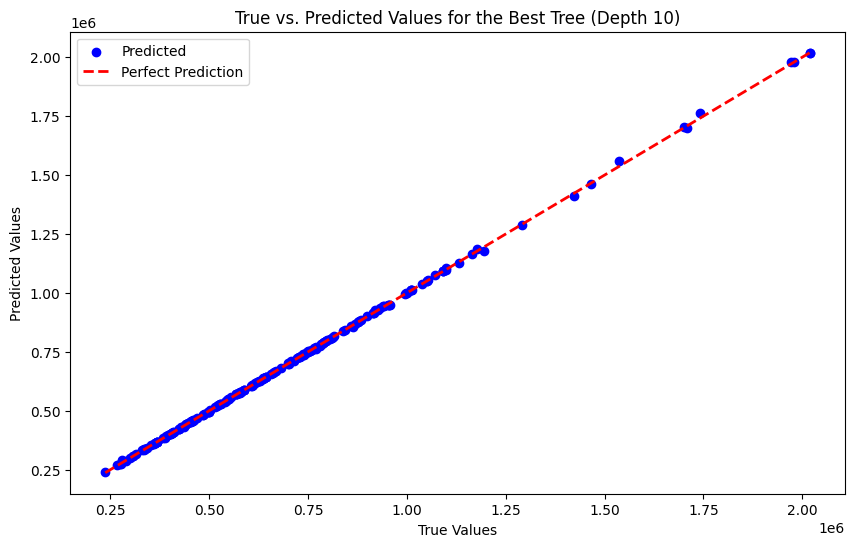

<ipython-input-11-52164a31d54e>:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_tree, shade=True, color='blue')


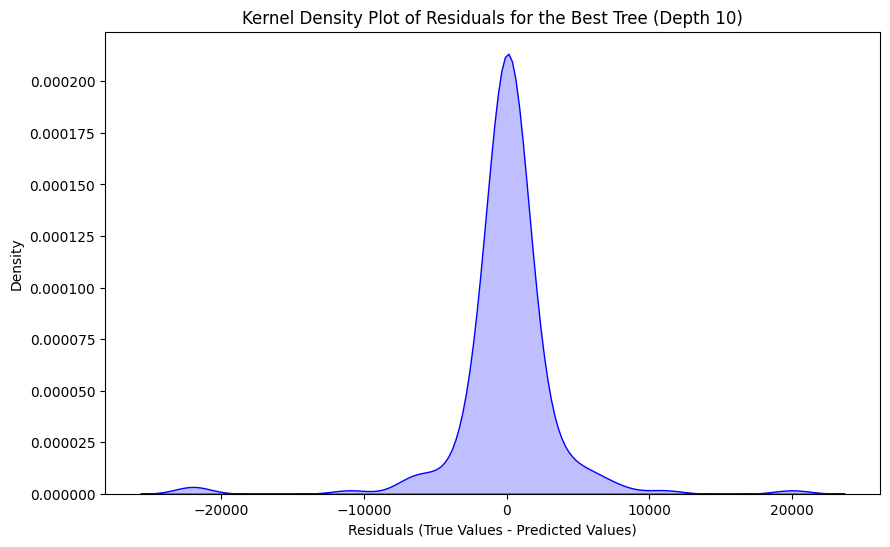

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

best_tree = DecisionTreeRegressor(max_depth=10, random_state=42)
best_tree.fit(X_train_encoded, y_train)
y_pred_tree = best_tree.predict(X_test_encoded)
#Create a scatter plot for predicted vs true
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tree, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values for the Best Tree (Depth 10)')
plt.legend()
plt.show()
#Calculate residuals
residuals_tree = y_test - y_pred_tree
#Create a kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_tree, shade=True, color='blue')
plt.xlabel('Residuals (True Values - Predicted Values)')
plt.title('Kernel Density Plot of Residuals for the Best Tree (Depth 10)')
plt.show()

The predicted values do line up along the diagonal line. Similarly the residuals are bell curve shaped around 0.

1.9

The regression tree had an R2 of 0.9998913447515495 and an RMSE of 3530.1935012775975. The linear model had an R2 of 1.0 and an RMSE of 3.849176798002242e-10. The linear model had a slighter better performance.

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

3.1

In [12]:
import pandas as pd

data = pd.read_csv('/content/sample_data/contraception_hw.csv')
#Tabulate
method_counts = data['method'].value_counts()
print("Tabulation of 'method' variable:")
print(method_counts)
#Cross-tabulate method and numberchildren
cross_tab = pd.crosstab(data['method'], data['numberChildren'], margins=True)
print("\nCross-tabulation of 'method' and 'numberChildren':")
print(cross_tab)
#Calculate the average number of children for each contraceptive method
average_children_per_method = data.groupby('method')['numberChildren'].mean()
print("\nAverage number of children for each contraceptive method:")
print(average_children_per_method)

Tabulation of 'method' variable:
1    629
3    511
2    333
Name: method, dtype: int64

Cross-tabulation of 'method' and 'numberChildren':
numberChildren   0    1    2    3    4    5   6   7   8   9  10  11  12  13  \
method                                                                        
1               95  143  114   70   57   44  35  18  29   5   9   6   4   0   
2                0   46   56   70   62   36  27  19   9   3   2   2   0   1   
3                2   87  106  119   78   55  30  12   9   8   0   3   0   1   
All             97  276  276  259  197  135  92  49  47  16  11  11   4   2   

numberChildren  16   All  
method                    
1                0   629  
2                0   333  
3                1   511  
All              1  1473  

Average number of children for each contraceptive method:
method
1   2.93
2   3.74
3   3.35
Name: numberChildren, dtype: float64


On average it seems that couples that use birth control pills have more children than those that don't.

3.2

In [13]:
from sklearn.model_selection import train_test_split

#Split the data
X = data.drop(columns=['method'])
y = data['method']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3.3

In [14]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

#create tree
regression_tree = DecisionTreeRegressor(random_state=42)
regression_tree.fit(X_train, y_train)
leaf_values = regression_tree.tree_.value.squeeze()
#print node values
print("Terminal Node Values:")
for i, value in enumerate(leaf_values):
    print(f"Node {i}: {value}")

Terminal Node Values:
Node 0: 1.930390492359932
Node 1: 1.0
Node 2: 2.2970414201183433
Node 3: 2.621212121212121
Node 4: 2.0
Node 5: 3.0
Node 6: 1.9060052219321149
Node 7: 1.0
Node 8: 2.5990783410138247
Node 9: 2.0
Node 10: 3.0


The terminal node values take continuous numerical values, such as 1.93, 2.30, and 2.62. These values do not correspond to any meaningful categories in the context of contraceptive method prediction. The issue here is that we used a regression tree, which is designed for predicting continuous numerical values, to predict contraceptive methods, which is not an appropriate use case.

3.4

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

# Initialize the classification tree model
classification_tree = DecisionTreeClassifier(random_state=42)

# Fit the classification tree to the data
classification_tree.fit(X_train, y_train)

# Make predictions on the test data
y_pred_classification = classification_tree.predict(X_test)

# Calculate accuracy as a measure of classification performance
accuracy = accuracy_score(y_test, y_pred_classification)
print("Accuracy:", accuracy)

# Print the tree structure
tree_structure = export_text(classification_tree, feature_names=list(X_train.columns))
print("Tree Structure:")
print(tree_structure)

Accuracy: 0.9966101694915255
Tree Structure:
|--- Unnamed: 0 <= 416.50
|   |--- class: 1
|--- Unnamed: 0 >  416.50
|   |--- Unnamed: 0 <= 642.50
|   |   |--- class: 2
|   |--- Unnamed: 0 >  642.50
|   |   |--- Unnamed: 0 <= 1000.50
|   |   |   |--- class: 3
|   |   |--- Unnamed: 0 >  1000.50
|   |   |   |--- Unnamed: 0 <= 1214.50
|   |   |   |   |--- class: 1
|   |   |   |--- Unnamed: 0 >  1214.50
|   |   |   |   |--- Unnamed: 0 <= 1320.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- Unnamed: 0 >  1320.50
|   |   |   |   |   |--- class: 3



The classification tree is designed for categorical prediction, with terminal nodes representing contraceptive method categories and binary splits based on the Unnamed 0 variable. It achieves high accuracy and provides a clear hierarchy of criteria for classifying individuals into the different contraceptive method groups. The classification tree algorithm uses the Unnamed 0 variable as the primary feature for making binary splits to classify individuals into different contraceptive method categories. In broad terms, the classification tree suggests that individuals with Unnamed 0 values within specific ranges are more likely to use particular contraceptive methods. Those with lower values are associated with no contraceptive use, while individuals with intermediate values are more likely to use long-term contraception methods. Those with higher values are inclined towards short-term contraception methods.

3.5

In [16]:
from sklearn.metrics import confusion_matrix

#compute confusion matrix
confusion = confusion_matrix(y_test, y_pred_classification)
print("Confusion Matrix:")
print(confusion)

#find accuracy
overall_accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
class_accuracies = np.diag(confusion) / np.sum(confusion, axis=1)
#output
print("Overall Accuracy:", overall_accuracy)
print("Accuracy for Class 1 (No Contraception):", class_accuracies[0])
print("Accuracy for Class 2 (Long Term):", class_accuracies[1])
print("Accuracy for Class 3 (Short Term):", class_accuracies[2])

Confusion Matrix:
[[130   0   0]
 [  1  70   0]
 [  0   0  94]]
Overall Accuracy: 0.9966101694915255
Accuracy for Class 1 (No Contraception): 1.0
Accuracy for Class 2 (Long Term): 0.9859154929577465
Accuracy for Class 3 (Short Term): 1.0


3.6

Using a linear probability model is inappropriate for this exercise as it is designed for binary outcomes and assumes a linear relationship between predictors and probabilities. However, the contraceptive method choice in this dataset involves three distinct categories, making it a multi-class classification problem. Linear probability models can lead to inaccurate predictions, difficulties in threshold selection, and invalid results. In contrast, classification trees are better suited for multi-class classification, offering a more accurate and interpretable approach for this exercise.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?